

# **Using Convolutional Neural Network (CNN) and Long Short-Term Memory (LSTM) for velocity detection of swimming fishes**






In [ ]:
timesteps = 25

In [ ]:
batch_size = 1


### **load the required libraries**


In [ ]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Embedding, Dropout, Activation
from keras.layers import TimeDistributed
import glob
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
from keras.models import model_from_yaml
from livelossplot import PlotLossesKeras
from keras import optimizers



### **Reshape images and make them Black and White**

In [ ]:
imagex = []
y = []

filenames = glob.glob("imagens/30/*.jpg")
images = [cv2.imread(img) for img in filenames]

for img in images:
    #print (img)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    a = resize(gray_image, preserve_range=True, output_shape=(224,224)).astype(int)      # reshaping to 224*224*3
    imagex.append(a)    
    y.append(0)

filenames = glob.glob("imagens/70/*.jpg")
images = [cv2.imread(img) for img in filenames]


for img in images:
    #print (img)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    a = resize(gray_image, preserve_range=True, output_shape=(224,224)).astype(int)      # reshaping to 224*224*3
    imagex.append(a)
    y.append(1)


X = np.array(imagex)
new = int(X.shape[0]/timesteps)
X = X.reshape(int(X.shape[0]/timesteps), timesteps, 50176)
X.shape



(8, 25, 50176)

In [ ]:
y = np.array(y)
y = y[::timesteps]
y = np_utils.to_categorical(y)
y.shape


(8, 2)

### **Build the sequential model using Time Distributed function**

In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', strides = 3, activation='relu')))
model.add(TimeDistributed(MaxPooling2D(pool_size=(3, 3),strides=(3, 3))))


### **Add the LSTM (Long Short Term Memory) algorithm**

In [ ]:
model = Sequential()
model.add(LSTM(120, return_sequences=False, stateful=False,
               batch_input_shape=(batch_size, timesteps, 50176)))
#model.add(LSTM(32, return_sequences=True, stateful=False))
#model.add(LSTM(32, stateful=False))
model.add(Dense(2, activation='exponential'))


#otim = optimizers.SGD(lr=0.1)


model.compile(loss='categorical_crossentropy',
              optimizer='SGD', 
              metrics=['accuracy'])




### **Train te model and save the weights**

In [ ]:
history = model.fit(X, y,
batch_size=batch_size, epochs=30, shuffle=False, verbose = 1)
#callbacks=[PlotLossesCallback()]
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Epoch 1/30
8/8 [==============================] - 6s 791ms/step - loss: 0.7940 - acc: 0.5000
Epoch 2/30
8/8 [==============================] - 4s 561ms/step - loss: 0.7205 - acc: 0.6250
Epoch 3/30
8/8 [==============================] - 4s 559ms/step - loss: 0.7197 - acc: 0.5000
Epoch 4/30
8/8 [==============================] - 4s 550ms/step - loss: 0.7127 - acc: 0.5000
Epoch 5/30
8/8 [==============================] - 4s 557ms/step - loss: 0.6994 - acc: 0.5000
Epoch 6/30
8/8 [==============================] - 4s 561ms/step - loss: 0.6839 - acc: 0.5000
Epoch 7/30
8/8 [==============================] - 4s 557ms/step - loss: 0.6680 - acc: 0.5000
Epoch 8/30
8/8 [==============================] - 4s 549ms/step - loss: 0.6522 - acc: 0.6250
Epoch 9/30
8/8 [==============================] - 4s 545ms/step - loss: 0.6369 - acc: 0.7500
Epoch 10/30
8/8 [==============================] - 4s 554ms/step - loss: 0.6220 - acc: 0.7500
Epoch 11/30
8/8 [==============================] - 5s 564ms/step - lo

### **Plot training accuracy and Loss**

dict_keys(['loss', 'acc'])


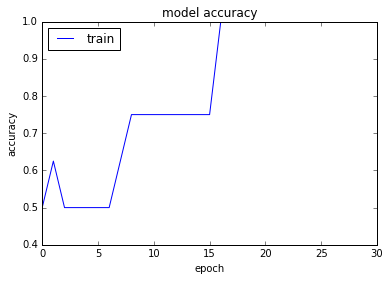

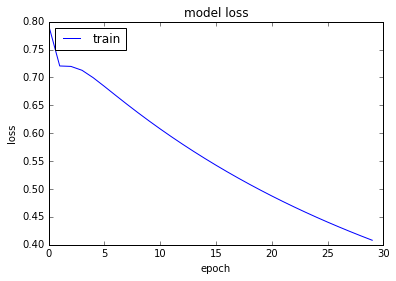

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **Predict velocity of the fishe (30 or 70 cms/s) in never seen group of frames**

In [ ]:
imagex = []

filenames = glob.glob("imagens/test/*.jpg")
images = [cv2.imread(img) for img in filenames]

for img in images:
    #print (img)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    a = resize(gray_image, preserve_range=True, output_shape=(224,224)).astype(int)      # reshaping to 224*224*3
    imagex.append(a)    
    
X2 = np.array(imagex)
X2 = X2.reshape(1, X2.shape[0], 50176)
model2 = Sequential()
model2.add(LSTM(120, return_sequences=False, stateful=False,
               batch_input_shape=(batch_size, timesteps, 50176)))
#model2.add(LSTM(32, return_sequences=True, stateful=False))
#model2.add(LSTM(32, stateful=False))
model2.add(Dense(2, activation='sigmoid'))
old_weights = model.get_weights()
model2.set_weights(old_weights)

model2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

resultado = model.predict_classes(X2, verbose=1)
if resultado[0] == 0:
        print("30")
else:
        print("70")

1/1 [==============================] - 0s 180ms/step
70


### **The same as before, but using a saved model**

In [ ]:
yaml_file = open('model.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

imagex = []

filenames = glob.glob("imagens/teste/*.jpg")
images = [cv2.imread(img) for img in filenames]

for img in images:
    #print (img)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    a = resize(gray_image, preserve_range=True, output_shape=(224,224)).astype(int)      # reshaping to 224*224*3
    imagex.append(a)    
    
X2 = np.array(imagex)

X2 = X2.reshape(batch_size, X2.shape[0], 50176)

model2 = Sequential()
model2.add(LSTM(120, return_sequences=False, stateful=False,
               batch_input_shape=(batch_size, X2.shape[1], 50176)))
#model2.add(LSTM(32, return_sequences=True, stateful=False))
#model2.add(LSTM(32, stateful=False))
model2.add(Dense(2, activation='sigmoid'))


old_weights = loaded_model.get_weights()
model2.set_weights(old_weights)

model2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

resultado = model2.predict_classes(X2, verbose=1)

if resultado[0] == 0:
        print("30 cm/s")
else:
        print("70 cm/s")

















Loaded model from disk
1/1 [==============================] - 1s 1s/step
70
